# Load Data

In [1]:
with open('qajokes.txt', 'r', encoding='utf-8') as f:
    qajokes = f.read()

In [2]:
len(qajokes)

9735078

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch 
import torch.nn as nn
from torch.nn import functional as F

In [5]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 12000
eval_interval = 1000
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2

# ------------

In [6]:
print("Using device:", device)

Using device: cpu


# Tokenise

For this simple exploration of the transformer architechture, I just used a simple method of tokenisation where every character is a single token. 

In [7]:
# here are all the unique characters that occur in this text

chars = sorted(list(set(qajokes)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
97


In [10]:
#create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [12]:
#encoding all data into a one dimensional tensor
data = torch.tensor(encode(qajokes), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:500]) # the 500 characters we looked at earier will to the GPT look like this

torch.Size([9735078]) torch.int64
tensor([57, 74, 91,  2, 69, 67, 80,  9, 86,  2, 36, 67, 84, 68, 75, 71,  2, 73,
        71, 86,  2, 82, 84, 71, 73, 80, 67, 80, 86, 33,  2, 36, 71, 69, 67, 87,
        85, 71,  2, 45, 71, 80,  2, 69, 81, 79, 71, 85,  2, 75, 80,  2, 67,  2,
        70, 75, 72, 72, 71, 84, 71, 80, 86,  2, 68, 81, 90, 16,  2, 42, 71, 91,
        81, 81, 81, 81, 81, 81, 81,  0,  0, 57, 74, 91,  2, 89, 67, 85,  2, 86,
        74, 71,  2, 79, 87, 85, 75, 69, 75, 67, 80,  2, 67, 84, 84, 71, 85, 86,
        71, 70, 33,  2, 42, 71,  2, 73, 81, 86,  2, 75, 80,  2, 86, 84, 71, 68,
        78, 71, 16,  0,  0, 38, 75, 70,  2, 91, 81, 87,  2, 74, 71, 67, 84,  2,
        67, 68, 81, 87, 86,  2, 86, 74, 71,  2, 73, 87, 91,  2, 89, 74, 81,  2,
        68, 78, 71, 89,  2, 74, 75, 85,  2, 71, 80, 86, 75, 84, 71,  2, 78, 81,
        86, 86, 71, 84, 91,  2, 89, 75, 80, 80, 75, 80, 73, 85,  2, 81, 80,  2,
        67,  2, 78, 75, 79, 81, 87, 85, 75, 80, 71, 33,  2, 42, 71,  2, 74, 67,
      

In [13]:
#find unique elemnts in the data tensor
chars = sorted(list(set(data.numpy().flatten())))

In [16]:
vocab_size = len(chars) 

In [17]:
vocab_size

97

In [20]:
# Splitting data into train and validation sets
split = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:split]
val_data = data[split:]

In [21]:
train_data.shape

torch.Size([8761570])

# Functions & Modules

In [22]:
#batching inputs

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    #print(x.shape, y.shape)
    x, y = x.to(device), y.to(device)
    return x, y


In [23]:

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            #print(f"X.shape: {X.shape}")
            # X; block size and batch size (inputs)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [24]:
def save_checkpoint(checkpoint, filename='checkpoint.pth.tar'):
    """Save checkpoint"""
    torch.save(checkpoint, f"/content/gdrive/MyDrive/{filename}")   

    #"/content/gdrive/MyDrive"

In [25]:
def load_checkpoint(checkpoint, model, optimizer):
    """Load checkpoint"""
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [28]:

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B,T,head_size)
        q = self.query(x) # (B,T,head_size)

        #Next, this computes attention scores (aka affinities)
        #test
        weights = q @ k.transpose(-2,-1) * k.shape[-1] ** -0.5 # Scales attention
        weights = weights.masked_fill(self.tril == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        v = self.value(x)
        #print(f"v.shape: {v.shape}")
        #print(f"weights.shape: {weights.shape}")
        out = weights @ v
        #print(f"out.shape in head: {out.shape}")
        return out



In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #print(f"x.shape in mha: {x.shape}")
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(f"out.shape in mha: {out.shape}")
        out = self.dropout(self.proj(out))
        return out

In [30]:
#Computational components

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed * 4),
            nn.ReLU(),
            nn.Linear(n_embed * 4, n_embed), 
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)



In [31]:
class Block(nn.Module):

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.mha = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.mha(self.ln1(x)) # 'x +' this is a skip connection
        x = x + self.ffwd(self.ln2(x))
        return x


# Main Constructor

In [ ]:

#nn.Module is the base class for all neural network modules in PyTorch
#This is the constructor
class JokePT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        #nn.embedding is a module that takes in a tensor of size (batch_size, seq_len) 
        #and returns a tensor of size (batch_size, seq_len, embedding_dim)
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.positional_encoding = nn.Embedding(block_size, n_embed) #embeds position in the sequence
        self.blocks = nn.Sequential(*[Block(n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed) #f for final
        self.lm_head = nn.Linear(n_embed, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)                

    
    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        # logits are the raw, unnormalized outputs of the model
        B, T = idx.shape
        token_embed = self.token_embedding_table(idx) # (B,T,C)
        pos_embed = self.positional_encoding(torch.arange(T, device = device)) # ints from 0 -> T-1 (T,C)
        embed = token_embed + pos_embed # (B,T,C)
        embed = self.blocks(embed) # (B,T,C)
        embed = self.ln_f(embed) # (B,T,C)
        logits = self.lm_head(embed) # (B,T,V) v being vocab_size

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # (B,T,C) -> (B*T,C) for ease in using F.cross_entropy
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets) #loss function

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities (takes input vector of real 
            # numbers and returns a vector of probabilities that sum to 1)
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


model = JokePT()
model = model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) #prints params


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate)

# Loss f' and Main training loop

In [ ]:
Ls = []

for iter in range(max_iters): # increase number of steps for good results... 
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint, filename='checkpoint-03.pth.tar')
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    Ls.append(loss.item())



step 0: train loss 1.2782, val loss 1.2889
step 1000: train loss 1.1954, val loss 1.2120
step 2000: train loss 1.1461, val loss 1.1691
step 3000: train loss 1.1020, val loss 1.1306
step 4000: train loss 1.0696, val loss 1.1065
step 5000: train loss 1.0451, val loss 1.0887
step 6000: train loss 1.0264, val loss 1.0677
step 7000: train loss 1.0086, val loss 1.0625
step 8000: train loss 0.9974, val loss 1.0531
step 9000: train loss 0.9803, val loss 1.0413
step 10000: train loss 0.9676, val loss 1.0362
step 11000: train loss 0.9573, val loss 1.0322


Loss over time (iterations):


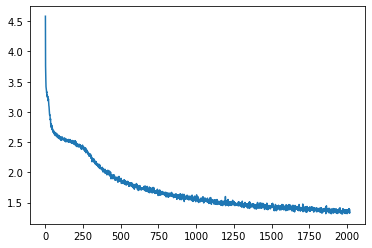

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot decrease in loss over time
xs = []
ys = []
for x, y in enumerate(Ls):
    xs.append(x)
    ys.append(y)

print("Loss over time (iterations):")
plt.plot(xs, ys)
plt.show()
plt.savefig('/content/gdrive/MyDrive/loss_over_time03.png')

In [ ]:
#Load model with map_location=torch.device('cpu')
model = torch.load('/content/gdrive/MyDrive/checkpoint-03.pth.tar', map_location=torch.device('cpu'))['model']

In [ ]:
context = torch.zeros((1, 256), dtype=torch.long) #256
context = context.to(device)
answer = decode(model.generate(context, max_new_tokens=1000)[0].tolist())
print(answer)

AttributeError: ignored